In [1]:
import matplotlib.pyplot as plt
import autograd
import autograd.numpy as np
import autograd.scipy as sp
import autograd.misc.optimizers
import numpy
import pandas as pd
from tqdm import tqdm
import sys
import time

In [2]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param=None):
        ''' Make objective functions: depending on whether or not you want to apply l2 regularization '''
        
        if reg_param is None:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                sum_error = np.sum(squared_error)
                return sum_error
            
            return objective, autograd.grad(objective)
            
        else:
            
            def objective(W, t):
                squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error
            
            return objective, autograd.grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                autograd.misc.optimizers.adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [3]:
# Load data
data = pd.read_csv('HW7_data.csv')
x = data['x'].values
y = data['y'].values

In [4]:
# Parameters BNN

###define rbf activation function
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':2000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params)

N = y.shape[0]
D = nn.weights.shape[1]

sigma_y = .5**2
weight_noise = 5**2
Sigma_W = weight_noise * np.eye(D)


Iteration 0 lower bound 65.11668053773148; gradient mag: 164.73210946091572
Iteration 100 lower bound 52.864360467566954; gradient mag: 56.95458639088454
Iteration 200 lower bound 49.42633385370296; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.733261895623144; gradient mag: 18.311751879565843
Iteration 400 lower bound 46.64774569354082; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.886915428058316; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.977925085924852; gradient mag: 20.354176994190937
Iteration 900 lower bound 24.278363637665738; gradient mag: 18.779125916898227
Iteration 1000 lower bound 22.02986716940495; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.210455188665925
Iteration 1200 lower bound 18.43436747168103; gradient mag: 15.09

In [5]:
# Parameters NF
h = np.tanh

# defined later
# u = bnn_joint

q_0_mu = np.array([0]*D)
q_0_sigma = 1
num_samples = 1000

num_flows = 16
lambda_flows = np.array([np.array([1.]*D + [0.]*D + [0.])]*num_flows)

m = 10000
step_size = .001

use_adam = True


In [6]:
# Samples from initial distribution
samples = np.random.multivariate_normal(q_0_mu, q_0_sigma*np.eye(D), num_samples)

In [7]:
# lambda u, w, b

# Flow multiple times
def flow_samples(lambda_flows, z, h):
    for lambda_flow in lambda_flows:
        z = flow_once(lambda_flow, z, h)
    return z

# Flow once
def flow_once(lambda_flow, z, h):
    D = (lambda_flow.shape[0]-1)//2
    z @ lambda_flow[D:2*D].reshape(-1, 1)
    return z + h((z @ lambda_flow[D:2*D].reshape(-1, 1))+lambda_flow[-1]) @ lambda_flow[:D].reshape(1, -1)

# Psi
def psi(lambda_flow, z, h):
    D = (lambda_flow.shape[0]-1)//2
    return (1-h((z @ lambda_flow[D:2*D].reshape(-1, 1))+lambda_flow[-1])**2) * lambda_flow[D:2*D]

In [8]:
# Calculate energy bound
def energy_bound(lambda_flows, z, h, u, beta=1.):
    D = (lambda_flows.shape[1]-1)//2
    initial_exp = np.mean(np.log(sp.stats.norm.pdf(z, loc=q_0_mu, scale=np.sqrt(q_0_sigma))))
    joint_exp = beta*np.mean(np.log(u(flow_samples(lambda_flows, z, h))))
    flow_exp = 0.
    for lambda_flow in lambda_flows:
        flow_exp += np.mean(np.log(np.abs(1 + np.dot(psi(lambda_flow, z, h), lambda_flow[:D]))))
        z = flow_once(lambda_flow, z, h)
    return initial_exp - joint_exp - flow_exp

In [9]:
def get_joint_exp(lambda_flows, z, h):
    return np.mean(np.log(u(flow_samples(lambda_flows, z, h))))

In [10]:
def get_flow_exp(lambda_flows, z, h):
    D = (lambda_flows.shape[1]-1)//2
    flow_exp = 0
    for lambda_flow in lambda_flows:
        flow_exp += np.mean(np.log(np.abs(1 + np.dot(psi(lambda_flow, z, h), lambda_flow[:D]))))
        z = flow_once(lambda_flow, z, h)
        
    return flow_exp

In [11]:
def get_initial_exp(z):
    return np.mean(np.log(sp.stats.norm.pdf(z, loc=q_0_mu, scale=np.sqrt(q_0_sigma))))

In [12]:
grad_energy_bound = autograd.grad(energy_bound)

In [13]:
def get_beta(i):
#     return min(1, 0.01+i/10000)
    return 2+i/1000

In [14]:
# From Cooper
start = time.time()
def callback(x, i, g):
#     samples_flowed = flow_samples(x, samples, h)
    
#     # Debug
#     initial_hist[i] = get_initial_exp(samples)
#     energy_hist[i] = energy_bound(x, samples, h, u)
#     joint_hist[i] = get_joint_exp(x, samples, h)
#     flow_hist[i] = get_flow_exp(x, samples, h)
#     lambda_hist[i] = lambda_flows
    
#     # Plot
#     if i % 1000 == 0:
#         fig, ax = plt.subplots()
#         ax.contourf(X, Y, U_z, cmap='Reds', levels=15)
#         ax.scatter(samples_flowed[:, 0], samples_flowed[:, 1], alpha=.5)
#         plt.show()

    if(i%10 == 0):
        left = '['
        right = ']'
        eq = '=' * int(20*i/m)
        blank = ' ' * int(np.ceil(20*(1 - i/m)))
        sys.stdout.write("{0}{1}{2}{3}  {4:.3f}%  {5:.2f}s\r".format(
                         left, eq, blank, right, 100*i/m, time.time()-start))
        sys.stdout.flush()
    if(i==(m-1)):
        sys.stdout.write("{}\r".format(' '*50))
        sys.stdout.flush()
        print("[{}]  100%  {}".format(20*'=', time.time() - start))

In [15]:
def bnn_nf(Sigma_W, y_train, x_train, use_adam, lambda_flows, forward):
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)

    #define the log prior on the model parameters
    def log_prior(W):
    #         print('W_prior', W.shape)
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        return log_p_W

    #define the log likelihood
    def log_lklhd(W):
    #         print('W_lklhd', W.shape)
        S = W.shape[0]
        constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
        exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - forward(W, x_train))**2, axis=2).flatten()
        return constant + exponential

    #define the log joint density
    def bnn_joint(w):
        return log_lklhd(w) + log_prior(w)
    
    u = bnn_joint
    
    if use_adam:
        grad_energy_bound_lambda = lambda params, i : grad_energy_bound(params, samples, h, u, get_beta(i))
        lambda_flows = autograd.misc.optimizers.adam(grad_energy_bound_lambda, lambda_flows,
                                                     callback=callback, num_iters=m, step_size=step_size)
    else:
        for i in tqdm(range(m)):
            gradient = grad_energy_bound(lambda_flows, samples, h, get_beta(i))
            lambda_flows -= step_size*gradient

            callback(lambda_flows, i, gradient)
            
    return lambda_flows

In [16]:
initial_hist = np.empty(m)
energy_hist = np.empty(m)
joint_hist = np.empty(m)
flow_hist = np.empty(m)
lambda_hist = np.empty((m, *lambda_flows.shape))

lambda_flows = bnn_nf(Sigma_W, y.reshape((1, -1)), x.reshape((1, -1)), use_adam, lambda_flows, nn.forward)

/home/elisionducoeur/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


[====================]  100%  679.392635345459    


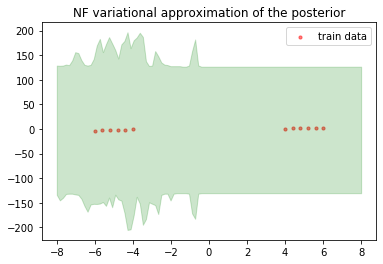

In [42]:
posterior_sample_size = 100
x_test = np.linspace(-8, 8, 100)

#sample from the posterior
posterior_samples = flow_samples(lambda_flows, np.random.multivariate_normal(q_0_mu, q_0_sigma*np.eye(D), posterior_sample_size), h)

#predict on x_test
y_pred = nn.forward(posterior_samples, x_test.reshape((1, -1))).reshape(posterior_sample_size, len(x_test))
# y_pred = y_pred + np.random.normal(0, sigma_y**0.5, size=(posterior_sample_size, len(x_test)))

#Gaussian log pdf
gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)

#compute the 95 percentiles of the posterior predictives
ub_bayes = np.percentile(y_pred, 97.5, axis=0)
lb_bayes = np.percentile(y_pred, 2.5, axis=0)

#visualize the posterior predictive distribution
plt.scatter(x, y, color='red', s=10, alpha=0.5, label='train data')
plt.fill_between(x_test, ub_bayes, lb_bayes, color='green', alpha=0.2)
plt.title('NF variational approximation of the posterior')
plt.legend(loc='best')